# Problem Set #2

# Hyun Ki Kim

# 01/22/2018

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook
import scipy.stats as sts
import scipy.optimize as opt
from scipy.integrate import quad

# 1. Some income data, lognormal distribution, and hypothesis testing

In [2]:
incomes = np.loadtxt('incomes.txt', delimiter=',', unpack=True)

# (a)

<IPython.core.display.Javascript object>


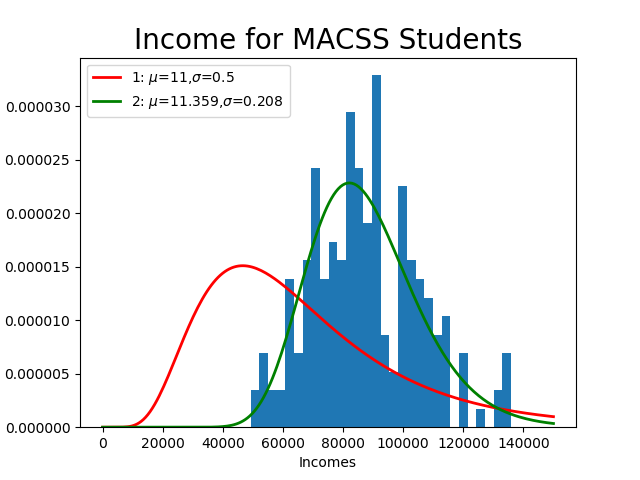

Text(0,0.5,'Frequency')

In [3]:
plt.hist(incomes, 30, normed=True)
plt.title("Income for MACSS Students", fontsize=20)
plt.xlabel("Incomes")
plt.ylabel("Frequency")

# (b)

In [4]:
def trunc_lognorm_pdf(xvals, mu, sigma, cutoff):
    
    if cutoff == "None":
        prob_notcut = 1.0 - sts.lognorm.cdf(0, loc=mu, s=sigma, scale=1)
    else:
        prob_notcut = (sts.lognorm.cdf(cutoff, loc=mu, s=sigma, scale=1) \
                       - sts.lognorm.cdf(0, loc=mu, s=sigma, scale=1))
    
    return ((1/(xvals * sigma * np.sqrt(2 * np.pi)) \
                 * np.exp( - (np.log(xvals) - mu)**2 / (2 * sigma**2))) / prob_notcut)

In [5]:
def log_lik_trunclognorm(xvals, mu, sigma, cutoff):
    
    pdf_vals = trunc_lognorm_pdf(xvals, mu, sigma, cutoff)
    ln_pdf_vals = np.log(pdf_vals)
    
    return ln_pdf_vals.sum()

mu_1 = 11.0
sig_1 = 0.5

print("Value of the log likelihood function:", log_lik_trunclognorm(incomes, mu_1, sig_1, 150000))

Value of the log likelihood function: -2385.85699781


# (c)

In [6]:
def crit(params, *args):
    
    mu, sigma = params
    xvals, cutoff = args
    
    return -log_lik_trunclognorm(xvals, mu, sigma, cutoff)

mu_init = 11
sig_init = 0.5
params_init = np.array([mu_init, sig_init])
mle_args = (incomes, 150000)
results = opt.minimize(crit, params_init, args=(mle_args), method='L-BFGS-B',
                       bounds=((0.1, None), (0.1, None)))
mu_MLE, sig_MLE = results.x
print("MLE mu:", mu_MLE, ", MLE sigma:", sig_MLE)

MLE mu: 11.3590244083 , MLE sigma: 0.208178530816


In [7]:
dist_pts = np.linspace(1e-10, 150000, 200)
plt.plot(dist_pts, trunc_lognorm_pdf(dist_pts, mu_1, sig_1, 150000),
         linewidth=2, color='r', label='1: $\mu$=11,$\sigma$=0.5')
plt.legend(loc='upper left')

plt.plot(dist_pts, trunc_lognorm_pdf(dist_pts, mu_MLE, sig_MLE, 150000),
         linewidth=2, color='g', label='2: $\mu$=11.359,$\sigma$=0.208')
plt.legend(loc='upper left')

In [8]:
print("Value of the likelihood function:", log_lik_trunclognorm(incomes, mu_MLE, sig_MLE, 150000))

Value of the likelihood function: -2241.71930137


In [9]:
OffDiagNeg = np.array([[1, -1], [-1, 1]])
vcv_mle = results.hess_inv * OffDiagNeg
print("Variance-covariance matrix:", vcv_mle)

Variance-covariance matrix: [[ 0.00022522 -0.00022522]
 [-0.00010284  0.00010284]]


# (d)

In [10]:
log_lik_h0 = log_lik_trunclognorm(incomes, mu_1, sig_1, 150000)
log_lik_mle = log_lik_trunclognorm(incomes, mu_MLE, sig_MLE, 150000)
LR_val = 2 * (log_lik_mle - log_lik_h0)
pval_h0 = 1.0 - sts.chi2.cdf(LR_val, 2)

print("P-value for the null hypothesis:", pval_h0)
print("Probability that the data in incomes.txt came from the distribution in part (b) is "\
     + (bool(pval_h0 < 0.05) * "un") + "likely.")

P-value for the null hypothesis: 0.0
Probability that the data in incomes.txt came from the distribution in part (b) is unlikely.


# (e)

In [11]:
more_than_100000 = quad(trunc_lognorm_pdf, 100000, 150000, args = (mu_MLE, sig_MLE, 150000))
less_than_75000 = quad(trunc_lognorm_pdf, 1e-10, 75000, args = (mu_MLE, sig_MLE, 150000))
print("The probability that I will earn more than $100,000: %.2f" %more_than_100000[0])
print("The probability that I will earn less than $75,000: %.2f" %less_than_75000[0])

The probability that I will earn more than $100,000: 0.23
The probability that I will earn less than $75,000: 0.26


# 2. Linear regression and MLE

In [12]:
data =  pd.read_csv('sick.txt')

# (a)

In [13]:
def get_error_sum(params,var_list):
    
    age, children, winter, sick= var_list
    B0, B1, B2, B3, sigma = params
    
    return np.sum((sick-B0-B1*age-B2*children-B3*winter)**2)

In [14]:
def crit(params,*args):
    
    age, children, winter, sick= args
    B0, B1, B2, B3, sigma = params
    log_lik_val = -len(age)/2*np.log(2*np.pi)-len(age)*np.log(sigma)-1/(2*sigma**2)*get_error_sum(params,(age, children, winter, sick))
    
    return -log_lik_val

age = data.age
children = data.children
winter = data.avgtemp_winter
sick = data.sick
params_init = (1,0,0,0,1)
results = opt.minimize(crit, params_init, args=((age, children, winter, sick)),  method = 'L-BFGS-B',bounds=((0.1, None),\
                       (0.01, None), (0.1, None), (None, -0.001), (0.001, None)))

print("B0:", results.x[0], "B1:", results.x[1], "B2:", results.x[2], "B3:", results.x[3], "sigma:", results.x[4])
print("Value of the log likelihood function:", results.fun)

B0: 0.25164473839 B1: 0.0129334516541 B2: 0.400501173933 B3: -0.00999169624959 sigma: 0.00301768236034
Value of the log likelihood function: -876.865063822


In [15]:
OffDiagNeg = np.eye(5)*2-1
vcv_mle = results.hess_inv.todense() * OffDiagNeg
print("Variance-covariance matrix:", vcv_mle)

Variance-covariance matrix: [[  2.30347554e+02   1.01330303e+01  -1.37202599e+02   9.66105410e-01
    3.55218820e+01]
 [  1.01330303e+01   4.45982696e-01   6.03679389e+00  -4.24024757e-02
   -1.56275821e+00]
 [ -1.37202599e+02   6.03679389e+00   8.17289707e+01   5.74926013e-01
    2.11587774e+01]
 [  9.66105410e-01  -4.24024757e-02   5.74926013e-01   4.09279770e-03
   -1.48922129e-01]
 [  3.55218820e+01  -1.56275821e+00   2.11587774e+01  -1.48922129e-01
    5.47791819e+00]]


# (b)

In [16]:
params_h0 = np.array([1,0,0,0,0.1])
log_lik_h0 = -crit(params_h0, age, children, winter,sick)
log_lik_mle = -crit(results.x, age, children, winter,sick)
pval_h0 = 1.0 - sts.chi2.cdf(2 * (log_lik_mle - log_lik_h0), 5)

print("P-value for the null hypothesis:", pval_h0)
print("Age, number of children, and average winter temperature have " \
     + (bool(pval_h0 < 0.05) * "no ") + "effect on the number of sick days.")

P-value for the null hypothesis: 0.0
Age, number of children, and average winter temperature have no effect on the number of sick days.
